# Model with pretrained embeddings
    - Glove embeddings. Vectors of 300 dim.
    - Model: Basic LSTM.


In [1]:
# Header
from __future__ import print_function

import numpy as np
import keras
print('Keras version: ', keras.__version__)

# GPU devices visible by python
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Limit memory usage
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


path = '/home/ubuntu/data/training/keras/'

Using TensorFlow backend.


Keras version:  2.0.1


## Preprocess data

In [2]:
# Import train and test data
data_path='/home/ubuntu/data/training/keras/aclImdb/'

X_train = np.load(data_path+'X_train.npy')
y_train = np.load(data_path+'y_train.npy')
X_test = np.load(data_path+'X_test.npy')
y_test = np.load(data_path+'y_test.npy')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(25000, 200) (25000,)
(25000, 200) (25000,)


## Load embeddings and join with the current dictionary

In [3]:
#Load embeddings
import pandas as pd
import csv
import pickle

# Load worddict
with open(data_path + 'worddict.pickle', 'rb') as pfile:
    worddict = pickle.load(pfile)

embed_dim = 300

embedding_path = '/home/ubuntu/data/training/keras/'

df_glove = pd.read_csv(embedding_path + "glove.6B."+str(embed_dim)+"d.txt", index_col=0 ,sep=' ',
                   header = None, quoting=csv.QUOTE_NONE, encoding='utf-8')

#Merge with the dictionary of the current texts: Inner join, only words in the corpus and in glove.
df_glove = df_glove.merge(pd.DataFrame.from_dict(worddict, orient='index'), left_index=True, right_index=True)
print('Merged words: ', df_glove.shape[0])

#Create dictionary: word_number_id --> [glove vector associated]
glove={}
for i,r in df_glove[:].iterrows():
    glove[int(r[0])] = [r[j] for j in range(1,embed_dim+1)]
print('Dictionary length: ', len(glove))

Merged words:  45934
Dictionary length:  45934


## Prepare sequences to model


In [4]:
#Create embeddings 3D tensors
max_len = 100

def embedd(x):
    r = np.zeros((max_len, embed_dim))
    pos = max_len-1
    for i in range(len(x),0,-1):
        found = True
        try:
            v = np.array([glove[x[i-1]]])
        except:
            found = False
        if found and pos>=0:
            r[pos,:] = v 
            pos += -1
    return r
        
X_train = np.array([embedd(s) for s in X_train], dtype=np.float32)
print('Train shape:', X_train.shape)

X_test = np.array([embedd(s) for s in X_test], dtype=np.float32)
print('Test shape:', X_test.shape)

Train shape: (25000, 100, 300)
Test shape: (25000, 100, 300)


## Build model

In [5]:
# Model
num_hidden_rnn = 128 #Num of neurons in the Recurent network 


from keras.models import Model
from keras.layers import Input, Embedding, SimpleRNN, LSTM, Dropout, Dense
from keras.optimizers import RMSprop

print('Build model 1 - Basic model...')

# LAYER 1: inputs
seq_prev_input = Input(shape=(max_len, embed_dim), dtype='float32') 

# LAYER 2: Create embedings
#embeds = Embedding(max_features, dim_embedings, input_length=max_len)(seq_prev_input)

# LAYERS 3: RNN - forwards LSTM with dropout
forward = LSTM(num_hidden_rnn, return_sequences=True,
                 dropout=0.3, recurrent_dropout=0.3, name='Forward1')(seq_prev_input)
rnn_out = LSTM(num_hidden_rnn, return_sequences=False,
                 dropout=0.3, recurrent_dropout=0.3, name='Forward2')(forward)


# LAYER 4: Dense layer to outputs - softmax activation
output = Dense(2, activation='softmax')(rnn_out)

# Model Architecture defined
model_1 = Model(inputs=seq_prev_input, outputs=output)
model_1.summary()

# Compile model and select optimizer
model_1.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


Build model 1 - Basic model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 300)          0         
_________________________________________________________________
Forward1 (LSTM)              (None, 100, 128)          219648    
_________________________________________________________________
Forward2 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 351,490.0
Trainable params: 351,490.0
Non-trainable params: 0.0
_________________________________________________________________


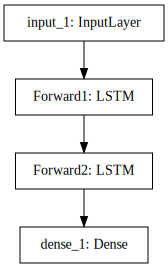

In [6]:
#Plot the model graph
from IPython.display import SVG
from keras.utils import vis_utils

SVG(vis_utils.model_to_dot(model_1).create(prog='dot', format='svg'))

In [7]:
# Train
batch_size = 128

print("Train...")
history = model_1.fit(X_train, y_train, batch_size=batch_size, epochs=20,
                      validation_data=(X_test, y_test))

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 81s - loss: 0.5943 - acc: 0.6735 - val_loss: 0.4694 - val_acc: 0.7841
Epoch 2/20
25000/25000 [==============================] - 80s - loss: 0.4850 - acc: 0.7700 - val_loss: 0.4190 - val_acc: 0.8102
Epoch 3/20
25000/25000 [==============================] - 81s - loss: 0.4275 - acc: 0.8032 - val_loss: 0.3765 - val_acc: 0.8308
Epoch 4/20
25000/25000 [==============================] - 80s - loss: 0.4039 - acc: 0.8157 - val_loss: 0.3640 - val_acc: 0.8350
Epoch 5/20
25000/25000 [==============================] - 80s - loss: 0.3854 - acc: 0.8256 - val_loss: 0.3617 - val_acc: 0.8348
Epoch 6/20
25000/25000 [==============================] - 80s - loss: 0.3674 - acc: 0.8352 - val_loss: 0.3437 - val_acc: 0.8461
Epoch 7/20
25000/25000 [==============================] - 80s - loss: 0.3519 - acc: 0.8438 - val_loss: 0.3371 - val_acc: 0.8502
Epoch 8/20
25000/25000 [=====================

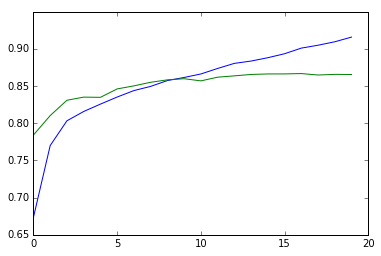

In [8]:
#Plot graphs in the notebook output
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

## Validate it

In [9]:
# Score and obtain probabilities
pred_test = model_1.predict(X_test)
print(pred_test.shape)

(25000, 2)


Accuracy:  0.86544
AUC:  0.9421550464


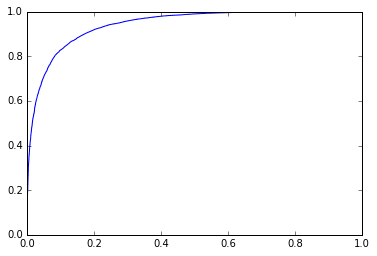

In [10]:
#Import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score

#Calculate accuracy with sklearn
print('Accuracy: ',accuracy_score(y_test, [1 if p>0.5 else 0 for p in pred_test[:,1]]))

#Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test[:,1])
print('AUC: ', auc(fpr, tpr) ) 

#Plot ROC curve
plt.plot(fpr, tpr)